Finetune the BERT on the 3 data variations:
- Original data: Fine-tune using original_train.csv.
- Neutral data: Fine-tune using neutral_train.csv.
- Balanced (mix) data: Fine-tune using mix_train.csv.

During fine-tuning, the process involves:
- Splitting the training dataset further into training and validation sets
- Training the model for a specific number of epochs on these datasets
- Saving the fine-tuned models for each data variation to be used later for evaluation.

In the end, I'll have 3 finetuned models
- One trained on the original data
- One trained on the neutral data
- One trained on the balanced (mix) data


...

After finetuning, the next step is to test each of these models.

In [2]:
import os
import sys
import time
import random
import datetime
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForTokenClassification, AutoModelForSequenceClassification

import seaborn as sns
import matplotlib.pyplot as plt


In [14]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [15]:
# Function to compute the accuracy of predictions vs labels
def flat_accuracy(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return np.sum(preds_flat == labels_flat) / len(labels_flat)

def flat_accuracy(preds, labels):
    """
    Compute the accuracy of predictions vs. labels.
    """
    # Convert logits to predicted class labels
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(preds_flat == labels_flat) / len(labels_flat)


In [16]:
# Helper function for formatting time

def format_time(elapsed):
    
    # Round to the nearest second
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [17]:
def load_data(file_path):
    """
    Loads data and converts Sentiment classes to numeric labels (1 for positive, 0 for negative).
    """

    df = pd.read_csv(file_path)
    df['Sentiment'] = df['Sentiment'].map({'pos': 1, 'neg': 0})

    df = df[:10]
    
    text = df['text'].tolist()
    labels = df['Sentiment'].tolist()

    return text, labels

In [18]:
train_file = '/work/SofieNørboMosegaard#5741/NLP/NLP-exam/data/original_train.csv'
train_text, train_labels = load_data(train_file)

print(train_text)
print(train_labels)

['vi skal ikke mange år tilbage før seerinteressen afhang af hvem der medvirkede i serien men fra 90erne begyndte man at kigge på hvem der stod bag serien joss whedon skabte således et kultfølge medbuffy  vampyrenes skræk19972003 og david chase sparkede døren ind hos hbo for de kreative hjerner bag kameraet med det banebrydende eposthe sopranos19992007 der som bekendt handler om gangsterentony soprano i dag er der stor prestige i at finde den nye store serieskaber og streamingtjenester er ikke blege for at give store navne frihed til at lave de serier som de nu engang har lyst til beau willimon er en af de helt store stjerner hans adaption af den britiske seriehouse of cardsblev en gigantisk succes for netflix som tjenestens første originale serie willimon stoppede på serien i 2016 knap et år senere blev det annonceret at han skulle stå bag en spektakulær fortælling om menneskets evne til at overkomme selv de værste forhindringer i bestræbelsen på at komme til mars the firststarter da 

In [19]:
# Load Danish BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("vesteinn/DanskBERT")
tokenizer

XLMRobertaTokenizerFast(name_or_path='vesteinn/DanskBERT', vocab_size=50005, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50004: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [20]:
# Tokenize data
input_ids = []
attention_masks = []

for text in train_text:
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens = True,
        max_length = 512,
        padding = "max_length",
        truncation = True,
        return_attention_mask = True,
        return_tensors = "pt",
    )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

In [21]:
# Convert to tensors
input_ids = torch.cat(input_ids, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(train_labels)

print(input_ids)
print(attention_masks)
print(labels)

tensor([[    0,   102,   142,  ...,  1371,   926,     2],
        [    0,  2992,   728,  ...,    82, 39622,     2],
        [    0,   133,   221,  ...,  3219,    52,     2],
        ...,
        [    0,    19,    45,  ..., 11998,    27,     2],
        [    0,   303,    63,  ..., 13365,    33,     2],
        [    0,   329,   574,  ...,   115,   538,     2]])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])
tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0])


In [77]:
# Create dataset
dataset = TensorDataset(input_ids, attention_masks, labels)
dataset[:5]

(tensor([[    0,   102,   142,  ...,  1371,   926,     2],
         [    0,  2992,   728,  ...,    82, 39622,     2],
         [    0,   133,   221,  ...,  3219,    52,     2],
         [    0,   710,    32,  ...,    99,    10,     2],
         [    0,   283,   425,  ...,  2296,    19,     2]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 tensor([0, 0, 1, 1, 1]))

In [78]:
# Create a 90-10 train-validation split

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Create the 90-10 train-validation split
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"{train_size:,} training samples")
print(f"{val_size:,} validation samples")

9 training samples
1 validation samples


In [79]:
# DataLoader

batch_size = 8  # 16, 32

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

validation_dataloader = DataLoader(val_dataset, batch_size = batch_size)

In [80]:
# Load Danish BERT model

#model = BertForSequenceClassification.from_pretrained(
model = AutoModelForSequenceClassification.from_pretrained(
    "vesteinn/DanskBERT",
    num_labels = 2, # binary, pos/neg
    
    # output_attentions = False,    # Whether the model returns attentions weights
    # output_hidden_states = False, # Whether the model returns all hidden-states
)

model.to(device)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at vesteinn/DanskBERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(50005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=7

In [81]:
# Optimizer
lr_in = 2e-5
eps_in = 1e-8

optimizer = AdamW(model.parameters(), lr = lr_in, eps = eps_in)

/home/ucloud/.local/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [82]:
epochs = 3

# Define learning rate scheduler
total_steps = len(train_dataloader) * epochs
print(total_steps)

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value?
                                            num_training_steps = total_steps)

#scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,
#                                                start_factor = 0.0,
#                                                total_iters = total_steps)

print(scheduler)

6


In [84]:
# Training loop

training_stats = []

print("Starting training...")

for epoch_i in range(epochs):
    print(f"Epoch {epoch_i + 1} / {epochs}")
    
    model.train()
    total_train_loss = 0 # Reset the total loss for this epoch

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device) # [0]: input ids 
        b_input_mask = batch[1].to(device) # [1]: attention masks
        b_labels = batch[2].to(device) # [2]: labels 

        model.zero_grad()

        # Forward pass
        result = model(b_input_ids,
                        attention_mask = b_input_mask,
                        labels = b_labels)

        loss = result.loss
        total_train_loss += loss.item() # Accumulate the training loss over all of the batches

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader) 
    print(f"Average training loss: {avg_train_loss}")

    # Validation
    print("Running Validation...")
    
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tells pytorch not to construct the compute graph during the forward pass
        with torch.no_grad():

            result = model(b_input_ids,
                            attention_mask = b_input_mask,
                            labels = b_labels)
            
            loss = result.loss     # Loss for validation batch
            logits = result.logits # Predicted logits

            # Move logits and labels to CPU
            preds = logits.detach().cpu().numpy()  # Predicted labels --> convert to numpy
            label_ids = b_labels.cpu().numpy()  # True labels --> convert labels to numpy

            # Accumulate the validation loss
            total_eval_loss += loss.item()

            # Calculate the accuracy for this batch of test sentences + accumulate it over all batches
            #total_eval_accuracy += flat_accuracy(logits, label_ids)
            total_eval_accuracy += flat_accuracy(preds, label_ids)
            
    # Report the final accuracy for the validation run
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print(f"Validation accuracy: {avg_val_accuracy}")

    # Calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    print(f"Validation loss: {avg_val_loss}")

    # Save all stats
    training_stats.append({
        'epoch': epoch_i + 1,
        'Training loss': avg_train_loss,
        'Validation loss': avg_val_loss,
        'Validation accuracy': avg_val_accuracy
    })


print("Training complete!")


# Save the fine-tuned model
output_model_dir = "/work/SofieNørboMosegaard#5741/NLP/NLP-exam/finetuned_models/BERT_finetuned_original"
model.save_pretrained(output_model_dir)
tokenizer.save_pretrained(output_model_dir)
print(f"Model saved to {output_model_dir}")

# saved format:
## config.json: model's configuration (i.e., number of labels, model type, architecture...)
## model.safetensors: model's weights
## special_tokens_map.json + tokenizer_config.json: tokenizer-related configurations
## tokenizer.json: tokenizer vocabulary and settings

# add Early stopping 


Starting training...
Epoch 1 / 3
Average training loss: 0.6308940052986145
Running Validation...
Validation accuracy: 1.0
Validation loss: 0.6591392159461975
Epoch 2 / 3
Average training loss: 0.6562580764293671
Running Validation...
Validation accuracy: 1.0
Validation loss: 0.6415131688117981
Epoch 3 / 3
Average training loss: 0.6587134003639221
Running Validation...
Validation accuracy: 1.0
Validation loss: 0.6415131688117981
Training complete!
Model saved to /work/SofieNørboMosegaard#5741/NLP/NLP-exam/finetuned_models/


In [93]:
df_stats = pd.DataFrame(training_stats).set_index('epoch')
df_stats

stats_file = os.path.join(output_model_dir, "training_stats.csv")
df_stats.to_csv(stats_file)

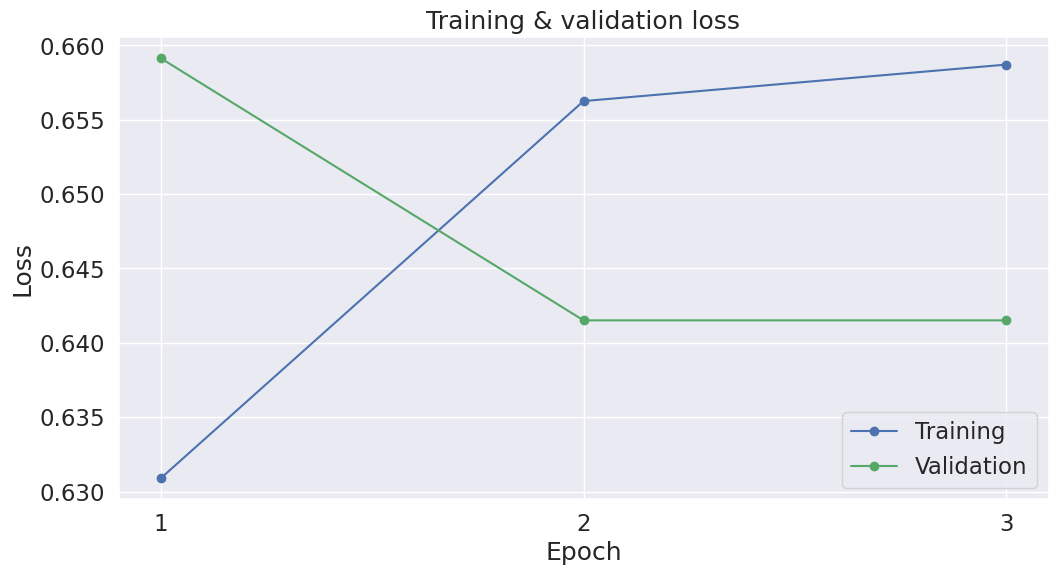

In [92]:
# Plot training and validation loss

sns.set(style = 'darkgrid')
sns.set(font_scale = 1.5)
plt.rcParams["figure.figsize"] = (12, 6)

plt.plot(df_stats['Training loss'], 'b-o', label = "Training")
plt.plot(df_stats['Validation loss'], 'g-o', label = "Validation")
plt.title("Training & validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(range(1, epochs + 1))
plt.show()

## Test

In [96]:
def load_data(file_path):

    df = pd.read_csv(file_path)
    df['Sentiment'] = df['Sentiment'].map({'pos': 1, 'neg': 0})
    
    df['text'] = df['text'].astype(str)
    text = df['text'].tolist()
    labels = df['Sentiment'].tolist()

    return text, labels

F_train_text, F_train_labels = load_data("/work/SofieNørboMosegaard#5741/NLP/NLP-exam/data_2/all_female_test.csv")
M_train_text, M_train_labels = load_data("/work/SofieNørboMosegaard#5741/NLP/NLP-exam/data_2/all_male_test.csv")

# make sure its the right format
print(type(F_train_text))  #  <class 'list'>
print(len(F_train_text))  # 814
print(type(F_train_text[0])) # str

<class 'list'>
814
<class 'str'>


In [97]:
# Load  tokenizer

tokenizer = AutoTokenizer.from_pretrained("vesteinn/DanskBERT")

#finetuned_model= "/work/SofieNørboMosegaard#5741/NLP/NLP-exam/finetuned_models/BERT_finetuned_original"
#tokenizer = AutoTokenizer.from_pretrained(finetuned_model)

tokenizer

XLMRobertaTokenizerFast(name_or_path='vesteinn/DanskBERT', vocab_size=50005, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50004: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [98]:
def tokenize_data(test_text, tokenizer):

    input_ids = []
    attention_masks = []

    for text in test_text:
        encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens = True,
        max_length = 512,
        padding = "max_length",
        truncation = True,
        return_attention_mask = True,
        return_tensors = "pt",
    )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim = 0)
    attention_masks = torch.cat(attention_masks, dim = 0)
    
    return input_ids, attention_masks

# Tokenize the female and male datasets
F_input_ids, F_attention_masks = tokenize_data(F_train_text, tokenizer)
M_input_ids, M_attention_masks = tokenize_data(M_train_text, tokenizer)

# Convert labels to tensors
F_labels = torch.tensor(F_train_labels)
M_labels = torch.tensor(M_train_labels)

# Verify shapes
print(F_input_ids.shape)  # Should be [814, 512]
print(F_attention_masks.shape)  # Should be [814, 512]
print(F_labels.shape)  # Should be [814]

torch.Size([814, 512])
torch.Size([814, 512])
torch.Size([814])


In [99]:
# Create dataset
F_dataset = TensorDataset(F_input_ids, F_attention_masks, F_labels)
M_dataset = TensorDataset(M_input_ids, M_attention_masks, M_labels)

batch_size = 8  # 16, 32

F_dataloader = DataLoader(F_dataset, batch_size = batch_size, shuffle = True)
M_dataloader = DataLoader(M_dataset, batch_size = batch_size, shuffle = True)

In [ ]:
# Load pretrained or fine-tuned  BERT

pretrained_model = AutoModelForSequenceClassification.from_pretrained("vesteinn/DanskBERT", num_labels = 2)
pretrained_model.to(device)

#finetuned_model = "/work/SofieNørboMosegaard#5741/NLP/NLP-exam/finetuned_models" # BERT_finetuned_original
#finetuned_model = AutoModelForSequenceClassification.from_pretrained(finetuned_model)
#finetuned_model.to(device)

In [104]:
def test_model(model, dataloader):

    model.eval()

    predictions = []
    true_labels = []

    for batch in dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask = b_input_mask)
            logits = outputs.logits

        # Convert logits to predicted class labels
        preds = torch.argmax(logits, dim = 1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(b_labels.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

    return metrics, predictions

In [89]:
F_metrics, F_predictions = test_model(pretrained_model, F_dataloader)

print(F_metrics)

{'accuracy': 0.7, 'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1_score': np.float64(0.0)}


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [90]:
M_metrics, M_predictions = test_model(pretrained_model, M_dataloader)

print(M_metrics)

{'accuracy': 0.7, 'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1_score': np.float64(0.0)}


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [92]:
def calculate_bias(female_preds, male_preds):

    #female_mean = np.mean(female_preds)
    #male_mean = np.mean(male_preds)
    #bias = male_mean - female_mean

    bias = np.mean(np.array(female_preds) - np.array(male_preds))

    return bias

pretrained_bias = calculate_bias(F_predictions, M_predictions)
print(f"Pretrained model bias (Male - Female): {pretrained_bias}")

Pretrained model bias (Male - Female): 0.0
